In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sensor-data/labapp3-data-new.txt


In [2]:
# pip install graphviz

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import classification_report

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler 


In [30]:
column_names = ["time", "nodeid", "temperature", "humidity", "light", "voltage"]
df = pd.read_csv('/kaggle/input/sensor-data/labapp3-data-new.txt', sep=' ', names=column_names, header=None)
np.random.seed(42)
df = df[df['nodeid'] <= 60]
df = df.sample(frac = 0.8)
df['time'] = pd.to_datetime(df['time'], unit='s')

# Preprocessing: Fill missing values
df['temperature'] = df['temperature'].interpolate(method='linear')
df['humidity'] = df['humidity'].interpolate(method='linear')
df['light'] = df['light'].interpolate(method='linear')
df = df.drop_duplicates()


df = df[df['temperature'] <= 150]
df = df[df['humidity'] >= -10]

In [31]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.20)
    Q3 = df[column].quantile(0.80)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[f'{column}_outlier'] = 1
    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), f'{column}_outlier'] = -1
    return df

# Apply the function to each sensor reading
df = detect_outliers_iqr(df, 'temperature')
df = detect_outliers_iqr(df, 'humidity')
df = detect_outliers_iqr(df, 'light')
df = detect_outliers_iqr(df, 'voltage')

# Optionally, you can create a combined outlier column
# A data point is an outlier if it's an outlier in any of the sensor readings
df['combined_outlier'] = df[['temperature_outlier', 'humidity_outlier', 'light_outlier', 'voltage_outlier']].min(axis=1)

In [32]:
df

,time,nodeid,temperature,humidity,light,voltage,temperature_outlier,humidity_outlier,light_outlier,voltage_outlier,combined_outlier
1115307,1970-01-13 19:49:10,31.0,22.9186,38.5993,158.24,2.54901,1,1,1,1,1
896508,1970-01-10 13:27:40,29.0,25.4666,36.2673,596.16,2.63964,1,1,1,1,1
1165336,1970-01-14 09:25:50,23.0,25.8194,34.3621,353.28,2.56000,1,1,1,1,1
1538320,1970-01-19 13:58:20,29.0,23.1832,37.8477,478.40,2.47467,1,1,1,1,1
1188730,1970-01-14 15:36:50,54.0,23.0558,42.0824,1611.84,2.53812,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
834278,1970-01-09 23:16:00,46.0,23.3792,38.8720,71.76,2.46440,1,1,1,1,1
2006118,1970-01-26 07:51:40,31.0,122.1530,42.3170,1317.44,2.25825,-1,1,1,1,-1
1971056,1970-01-25 19:39:40,28.0,20.2236,47.4731,1582.40,2.39484,1,1,1,1,1
995270,1970-01-11 14:32:20,9.0,22.1934,46.3281,1847.36,2.65143,1,1,-1,1,-1


In [33]:
df.shape

(1850292, 11)

In [34]:
df[df['combined_outlier'] == -1].shape

(432499, 11)

In [35]:
def visualize_dataframe(df, columns=None, plot_type='histogram'):
    """
    Visualizes the columns of a pandas DataFrame using the specified plot type.
    
    :param df: Pandas DataFrame.
    :param columns: List of columns to visualize. If None, all numeric columns are used.
    :param plot_type: Type of plot to use ('histogram' or 'boxplot').
    """
    if columns is None:
        columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    for column in columns:
        plt.figure(figsize=(10, 6))

        if plot_type == 'histogram':
            sns.histplot(df[column], kde=True)
            plt.title(f'Histogram of {column}')
        elif plot_type == 'boxplot':
            sns.boxplot(x=df[column])
            plt.title(f'Boxplot of {column}')
        
        plt.show()

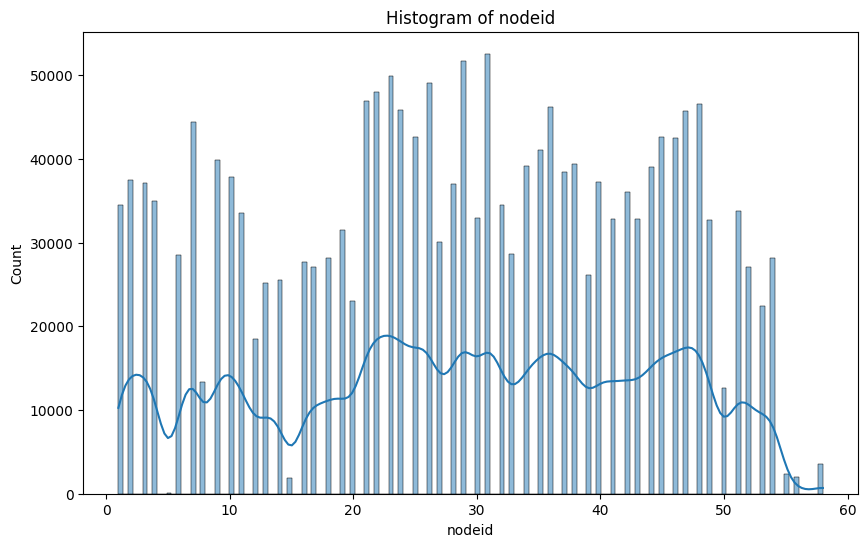

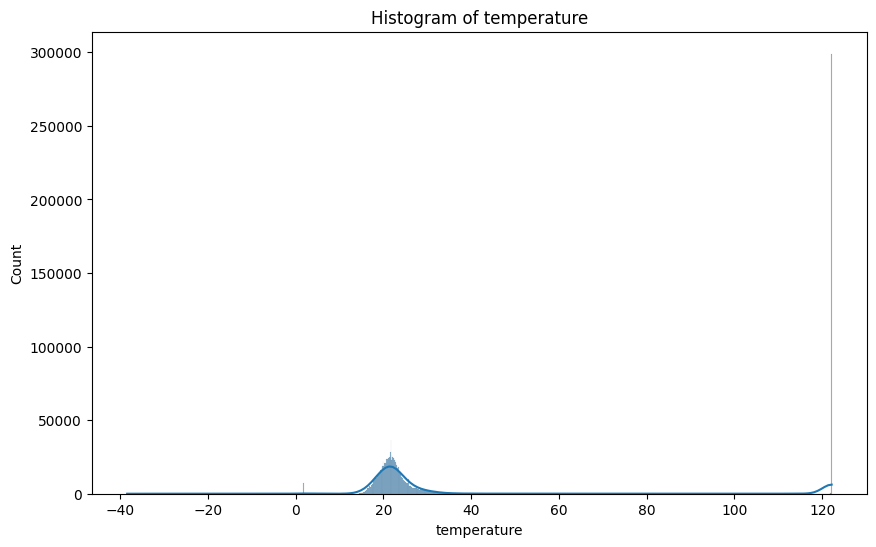

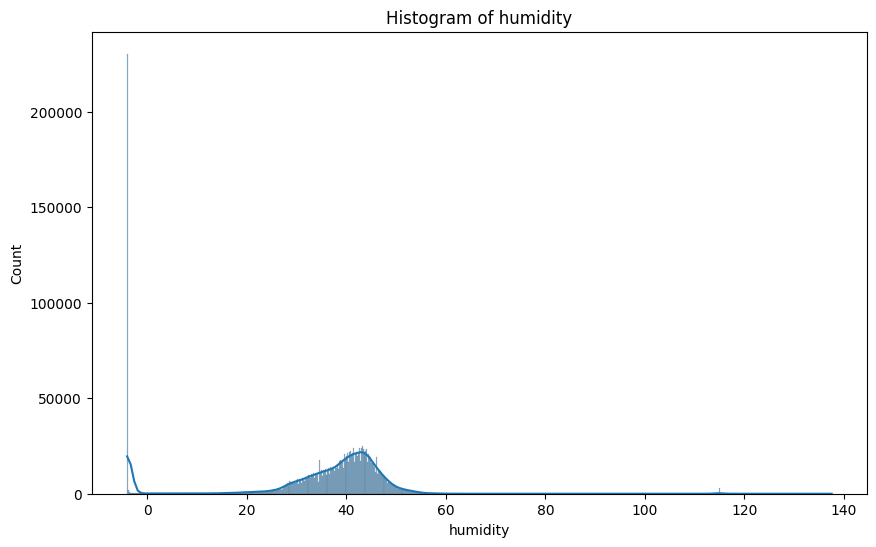

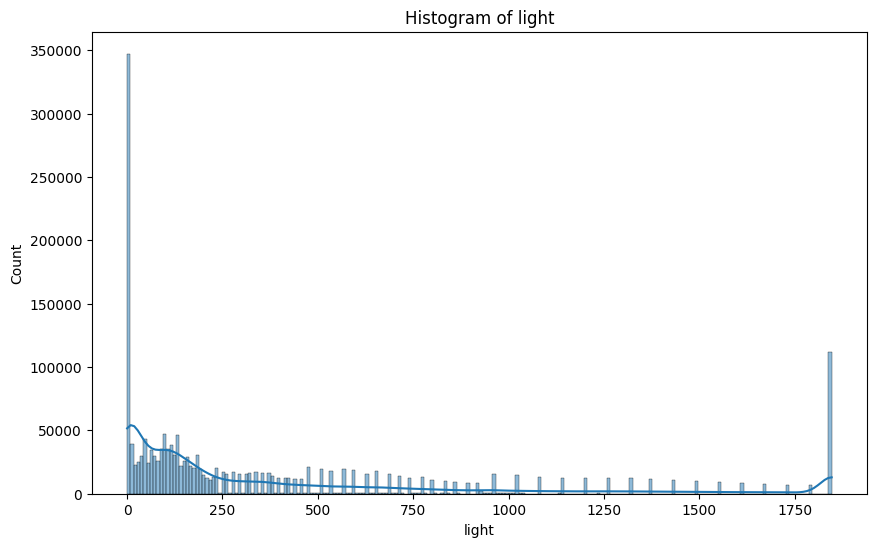

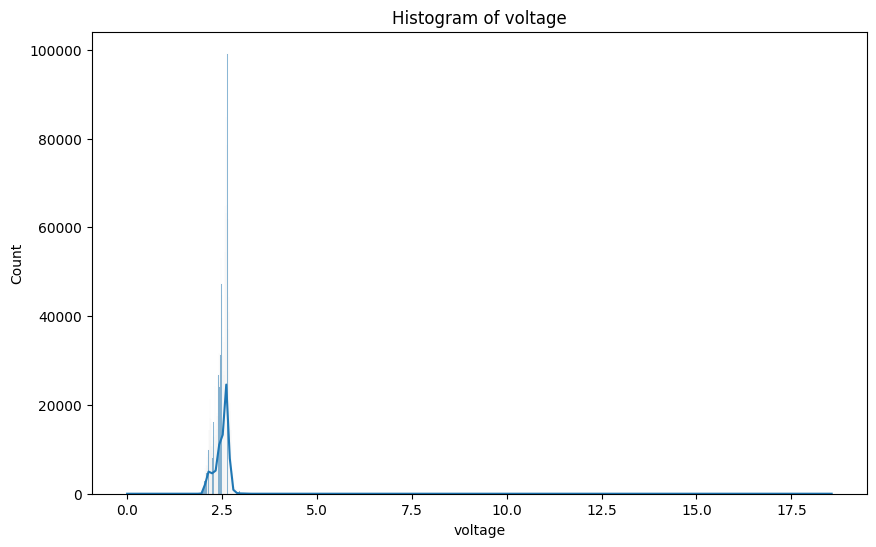

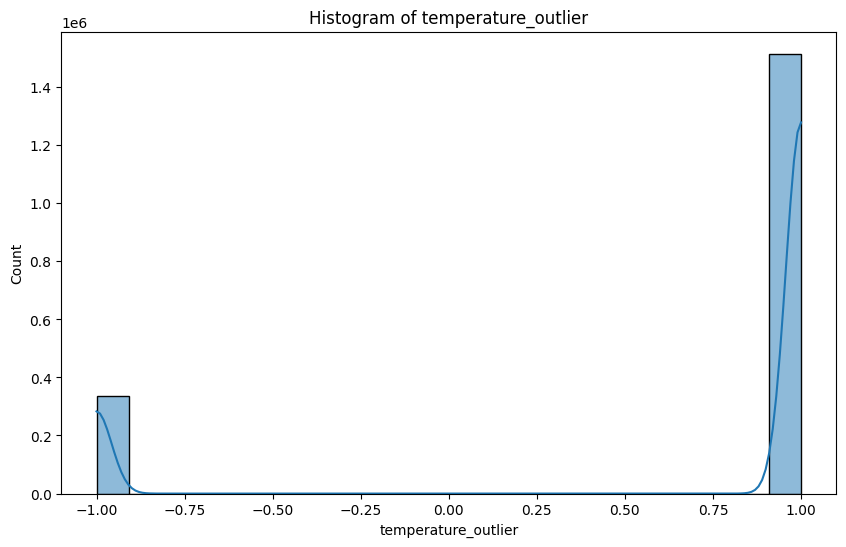

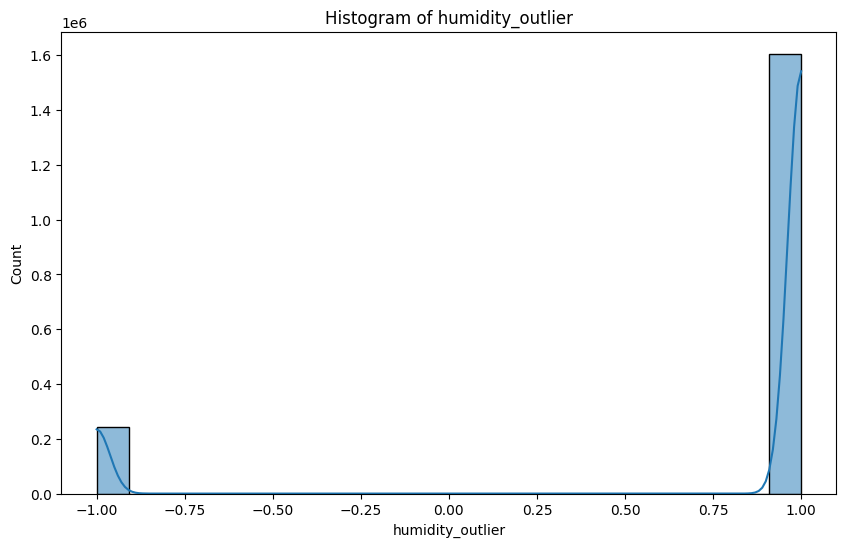

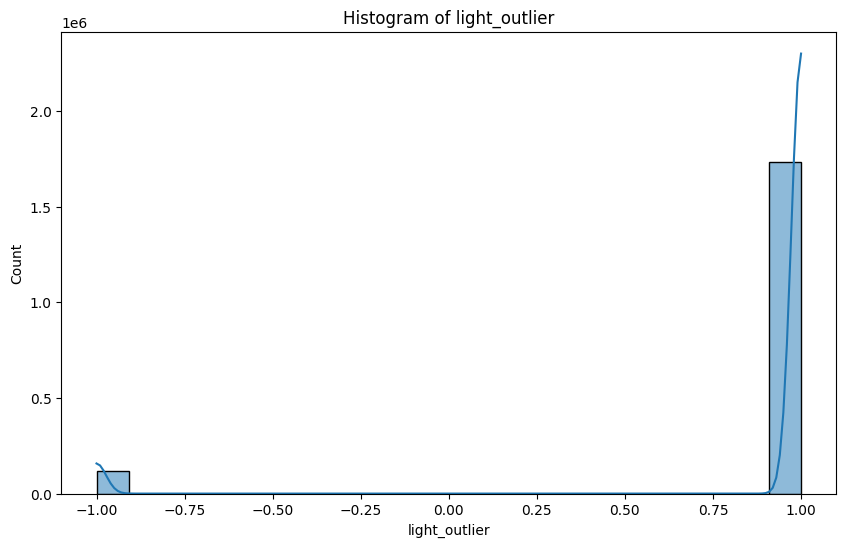

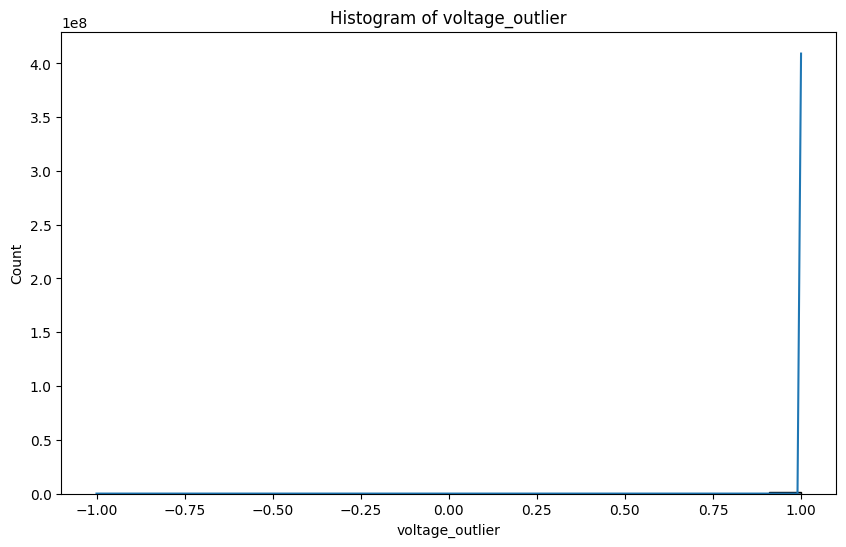

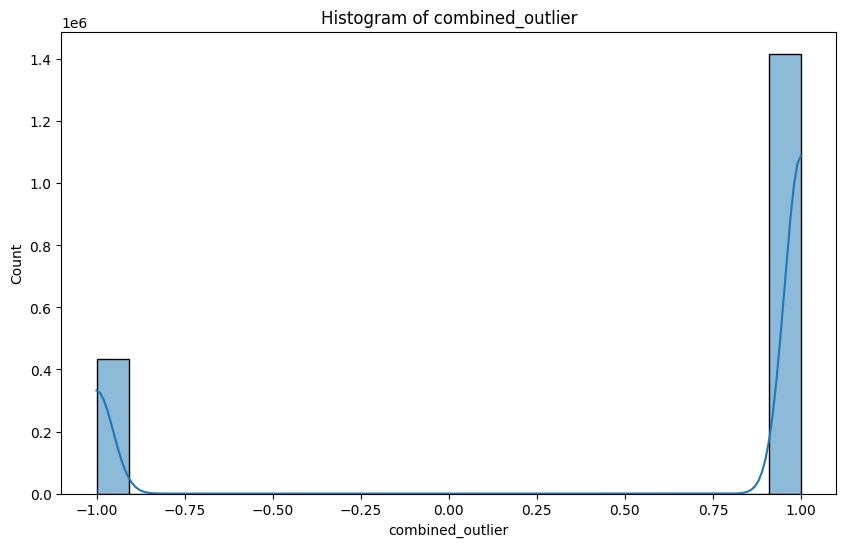

In [36]:
visualize_dataframe(df)

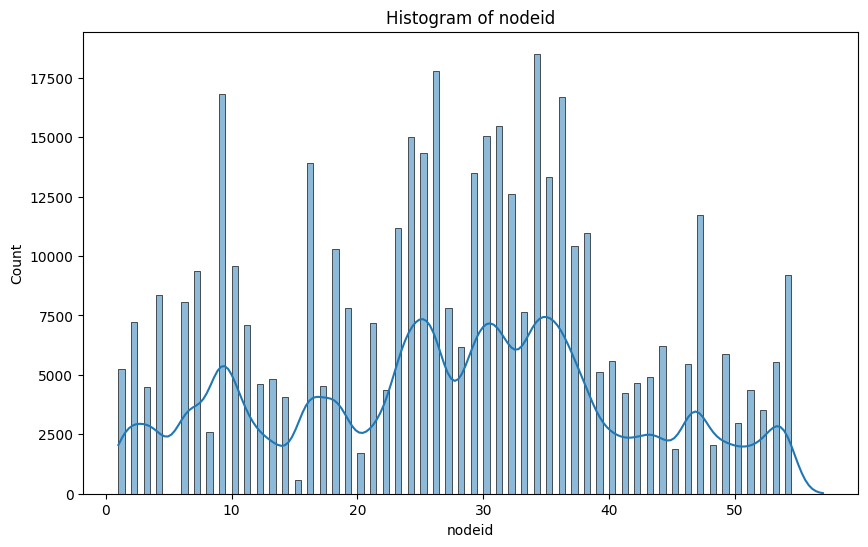

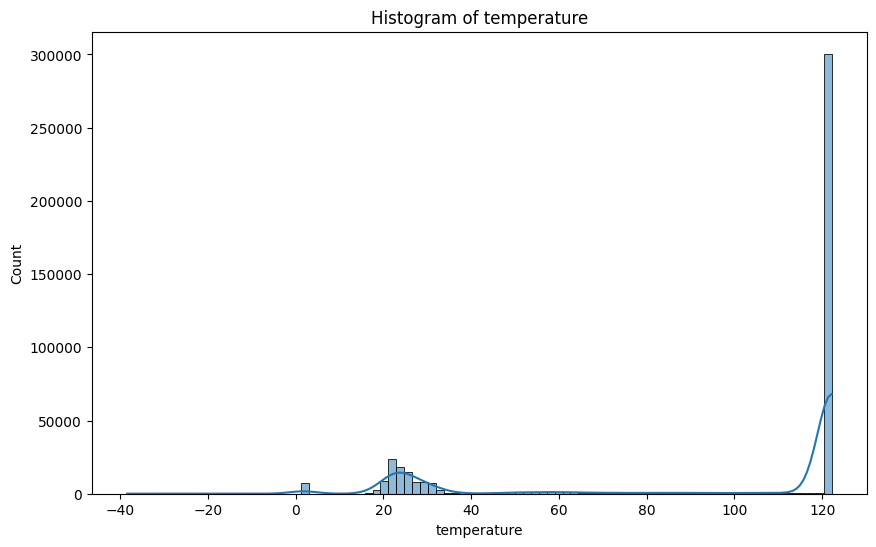

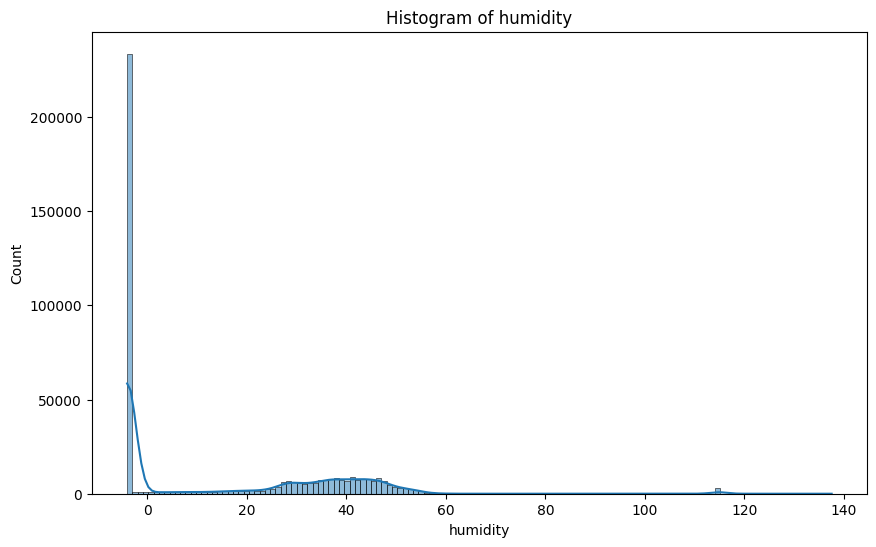

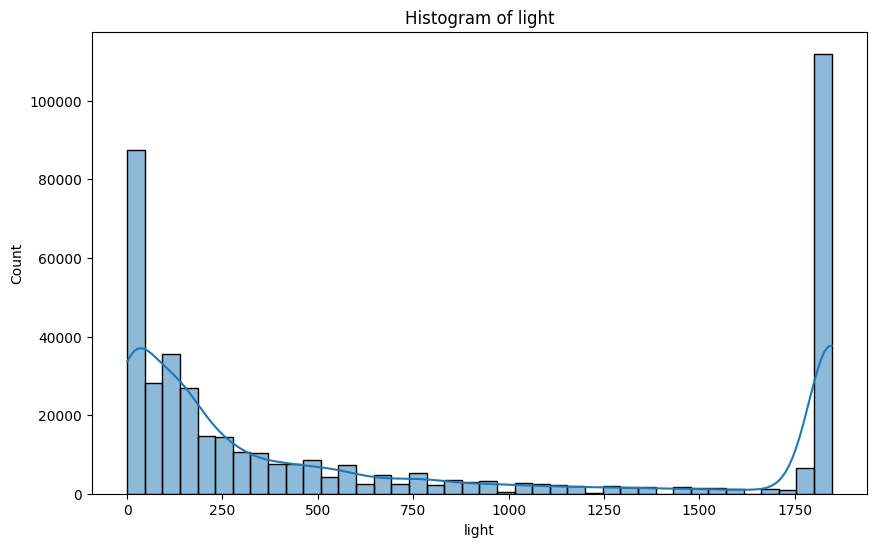

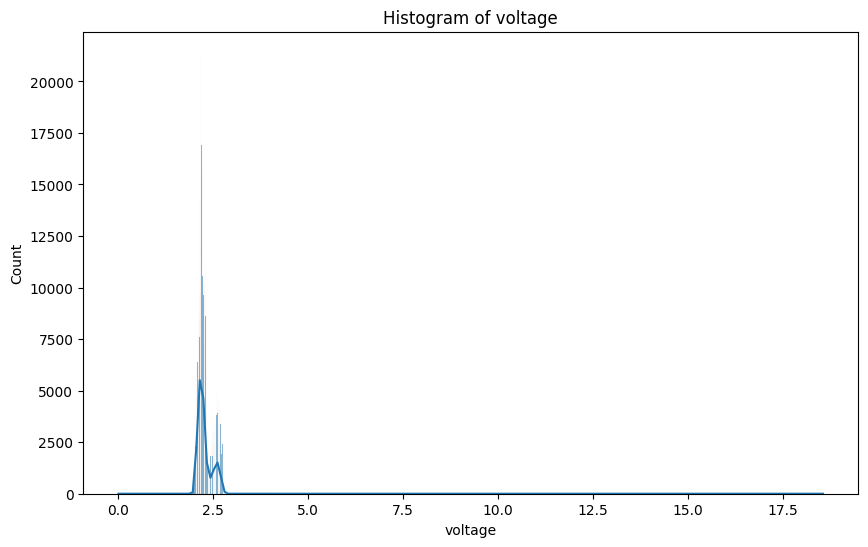

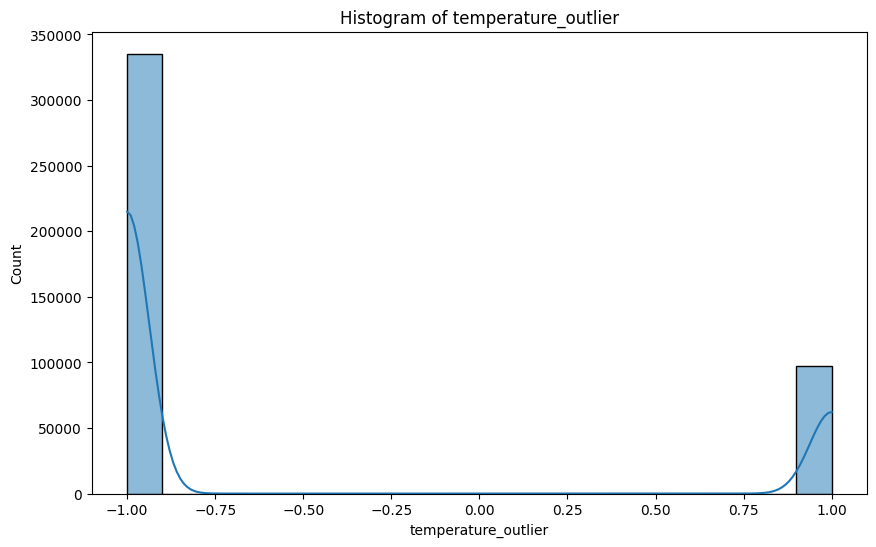

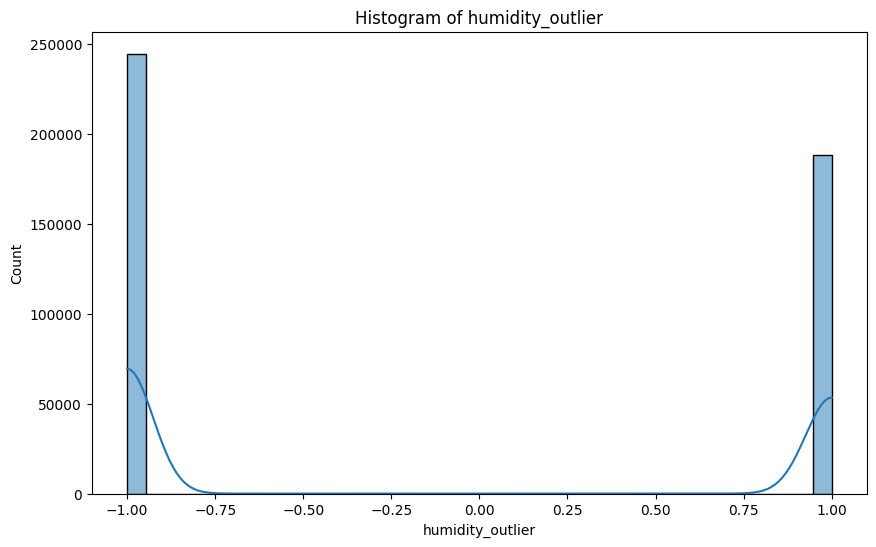

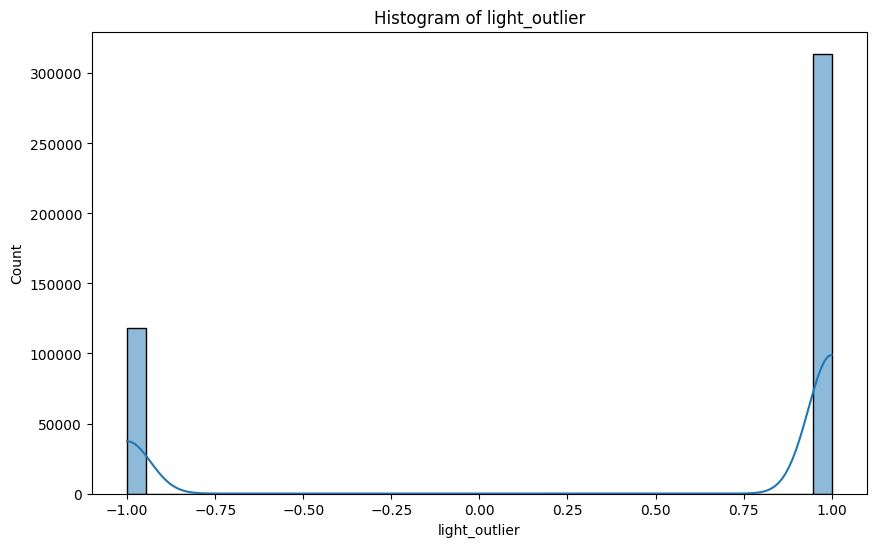

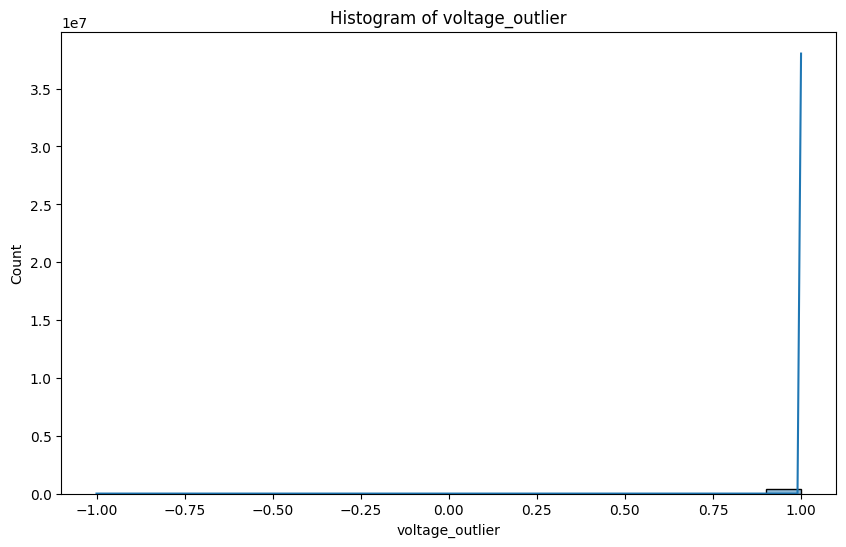

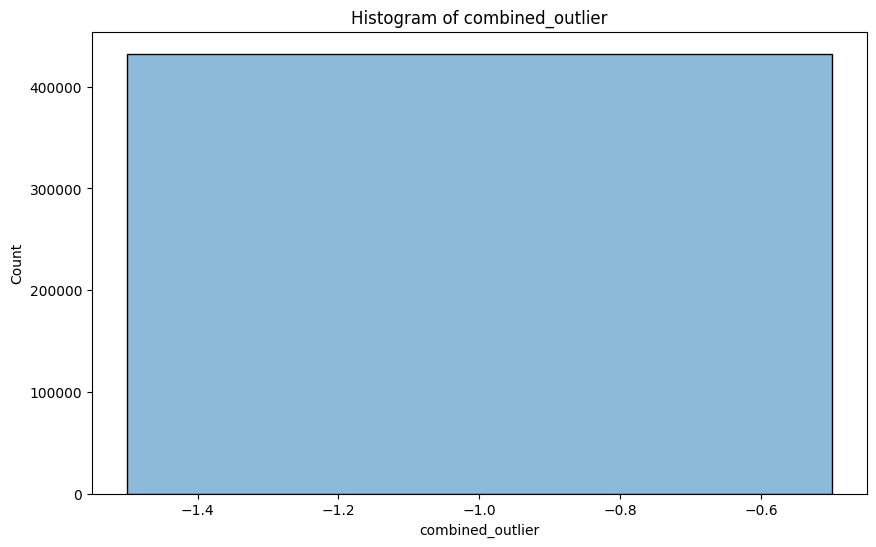

In [37]:
visualize_dataframe(df[df['combined_outlier'] == -1])

In [38]:
# Resetting the index to ensure 'nodeid' is treated as a column
# df = df.reset_index(drop=True)

# Normalize data sensor-wise
def normalize_sensor_data(df):
    scaler = MinMaxScaler()
    df[['temperature', 'humidity', 'light', 'voltage']] = scaler.fit_transform(df[['temperature', 'humidity', 'light', 'voltage']])
    return df

# Apply the normalization to each sensor's data
df_normalized = df.groupby('nodeid').apply(normalize_sensor_data)
df_normalized = df_normalized.reset_index(drop=True)

# Sorting the DataFrame by nodeid and timestamp
df_normalized.sort_values(by=['nodeid', 'time'], inplace=True)
# Show the first few rows of the normalized DataFrame
df_normalized.head()

df = df_normalized


In [39]:
df

,time,nodeid,temperature,humidity,light,voltage,temperature_outlier,humidity_outlier,light_outlier,voltage_outlier,combined_outlier
19837,1970-01-01 00:01:00,1.0,0.026611,0.750717,0.063118,0.916950,1,1,1,1,1
14570,1970-01-01 00:05:00,1.0,0.020075,0.775738,0.063118,0.900784,1,1,1,1,1
29950,1970-01-01 00:08:00,1.0,0.018768,0.781968,0.063118,0.900784,1,1,1,1,1
23759,1970-01-01 00:10:30,1.0,0.018581,0.784456,0.063118,0.900784,1,1,1,1,1
6178,1970-01-01 00:11:00,1.0,0.018768,0.783212,0.063118,0.900784,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1847202,1970-02-07 00:29:20,58.0,0.248927,0.594510,0.095504,0.050537,1,1,1,1,1
1848195,1970-02-07 05:02:00,58.0,0.129614,0.637777,0.214818,0.000000,1,1,1,1,1
1849379,1970-02-07 05:02:30,58.0,0.130472,0.637777,0.473264,0.000000,1,1,1,1,1
1848357,1970-02-07 09:35:10,58.0,0.704721,0.435106,0.060388,0.102375,1,1,1,1,1


In [40]:
window_size = 30  # Example window size
df['temp_rolling_avg'] = df.groupby('nodeid')['temperature'].transform(lambda x: x.rolling(window=window_size).mean())
df['humidity_rolling_avg'] = df.groupby('nodeid')['humidity'].transform(lambda x: x.rolling(window=window_size).mean())
df['light_rolling_avg'] = df.groupby('nodeid')['light'].transform(lambda x: x.rolling(window=window_size).mean())


df['temp_rolling_avg'] = df['temp_rolling_avg'].fillna(method='bfill')
df['humidity_rolling_avg'] = df['humidity_rolling_avg'].fillna(method='bfill')
df['light_rolling_avg'] = df['light_rolling_avg'].fillna(method='bfill')


# Add time-based features
df['hour_of_day'] = df['time'].dt.hour

In [41]:
df

,time,nodeid,temperature,humidity,light,voltage,temperature_outlier,humidity_outlier,light_outlier,voltage_outlier,combined_outlier,temp_rolling_avg,humidity_rolling_avg,light_rolling_avg,hour_of_day
19837,1970-01-01 00:01:00,1.0,0.026611,0.750717,0.063118,0.916950,1,1,1,1,1,0.018064,0.782149,0.061314,0
14570,1970-01-01 00:05:00,1.0,0.020075,0.775738,0.063118,0.900784,1,1,1,1,1,0.018064,0.782149,0.061314,0
29950,1970-01-01 00:08:00,1.0,0.018768,0.781968,0.063118,0.900784,1,1,1,1,1,0.018064,0.782149,0.061314,0
23759,1970-01-01 00:10:30,1.0,0.018581,0.784456,0.063118,0.900784,1,1,1,1,1,0.018064,0.782149,0.061314,0
6178,1970-01-01 00:11:00,1.0,0.018768,0.783212,0.063118,0.900784,1,1,1,1,1,0.018064,0.782149,0.061314,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847202,1970-02-07 00:29:20,58.0,0.248927,0.594510,0.095504,0.050537,1,1,1,1,1,0.610072,0.428339,0.018609,0
1848195,1970-02-07 05:02:00,58.0,0.129614,0.637777,0.214818,0.000000,1,1,1,1,1,0.591502,0.436500,0.025264,5
1849379,1970-02-07 05:02:30,58.0,0.130472,0.637777,0.473264,0.000000,1,1,1,1,1,0.572961,0.444662,0.040534,5
1848357,1970-02-07 09:35:10,58.0,0.704721,0.435106,0.060388,0.102375,1,1,1,1,1,0.573619,0.446028,0.042041,9


In [42]:
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# import numpy as np



# features = ['nodeid', 'temp_rolling_avg', 'humidity_rolling_avg', 'light_rolling_avg', 'voltage']


In [43]:
# def train_predict_rf(df, target_feature):
#     X = df[features].drop(target_feature, axis=1)
#     y = df[target_feature]

#     model = RandomForestRegressor(n_estimators=10, random_state=42)
#     model.fit(X, y)
    
#     # Making predictions
#     df[f'predicted_{target_feature}'] = model.predict(X)
#     return df

# # Training and predicting for each feature
# for feature in ['temp_rolling_avg', 'humidity_rolling_avg', 'light_rolling_avg']:
#     df = train_predict_rf(df, feature)


In [44]:
# def mark_anomalies(df, actual_cols, predicted_cols, threshold=0.15):
#     for actual_col, predicted_col in zip(actual_cols, predicted_cols):
#         deviation = np.abs(df[actual_col] - df[predicted_col]) / df[actual_col]
#         df[f'{actual_col}_anomaly'] = np.where(deviation > threshold, -1, 1)
#     return df

# actual_features = ['temp_rolling_avg', 'humidity_rolling_avg', 'light_rolling_avg']
# predicted_features = [f'predicted_{feature}' for feature in actual_features]

# df = mark_anomalies(df, actual_features, predicted_features)

# # Combining anomaly labels: if any one of the features is an anomaly, mark it as an anomaly
# anomaly_columns = [f'{feature}_anomaly' for feature in actual_features]
# df['rf-combined_anomaly'] = df[anomaly_columns].min(axis=1)


In [45]:
# df[df['rf-combined_anomaly'] == -1]

In [46]:
# df[df['combined_outlier'] == -1]

In [47]:
from sklearn.ensemble import IsolationForest


features = ['nodeid', 'temp_rolling_avg', 'humidity_rolling_avg', 'light_rolling_avg', 'voltage', 'hour_of_day']
iso = IsolationForest(contamination=0.23)
df['anomaly'] = iso.fit_predict(df[features])



# Optional: Identifying conditions for anomalies
# anomalous_conditions = df[df['anomaly'] == -1].groupby(['nodeid', 'voltage', 'hour_of_day']).size().reset_index(name='counts')
# print(anomalous_conditions.sort_values(by='counts', ascending=False))


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


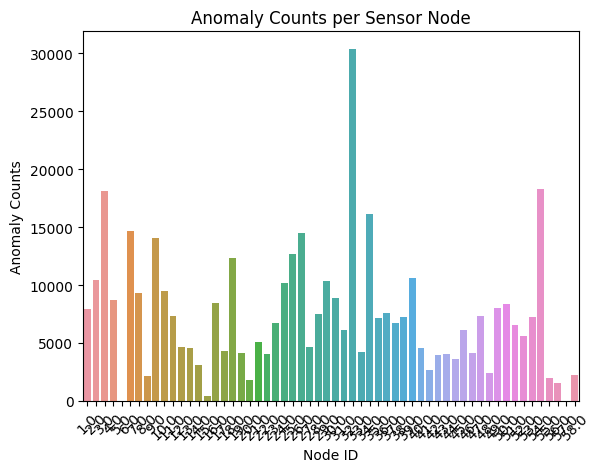

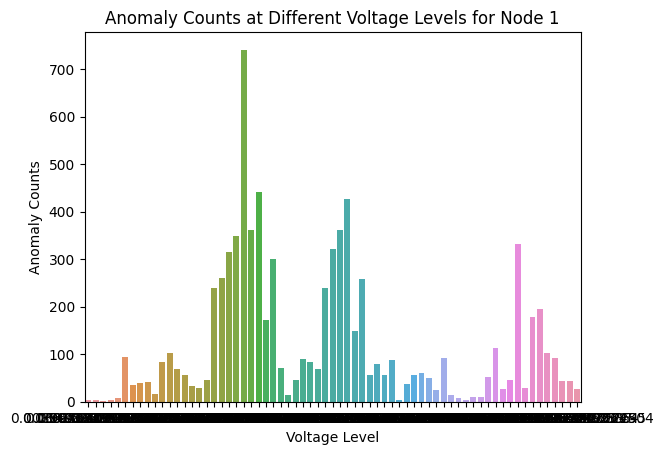

In [48]:
# Count the number of anomalies (-1 in the 'anomaly' column) for each node
sensor_anomaly_counts = df[df['anomaly'] == -1].groupby('nodeid')['anomaly'].count()

# Sort the counts to see which nodes have the highest number of anomalies
sorted_anomaly_counts = sensor_anomaly_counts.sort_values(ascending=False)
# print(sorted_anomaly_counts)

import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot of anomaly counts per node
sns.barplot(x=sorted_anomaly_counts.index, y=sorted_anomaly_counts.values)
plt.xlabel('Node ID')
plt.ylabel('Anomaly Counts')
plt.title('Anomaly Counts per Sensor Node')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

# Investigate anomalies at different voltage levels for a particular node
node_id = 1  # Replace with the ID of a node of interest

node_data = df[(df['nodeid'] == node_id) & (df['anomaly'] == -1)]
anomaly_conditions = node_data.groupby('voltage')['anomaly'].count().reset_index()

sns.barplot(x='voltage', y='anomaly', data=anomaly_conditions)
plt.xlabel('Voltage Level')
plt.ylabel('Anomaly Counts')
plt.title(f'Anomaly Counts at Different Voltage Levels for Node {node_id}')
plt.show()


In [50]:
df

,time,nodeid,temperature,humidity,light,voltage,temperature_outlier,humidity_outlier,light_outlier,voltage_outlier,combined_outlier,temp_rolling_avg,humidity_rolling_avg,light_rolling_avg,hour_of_day,anomaly
19837,1970-01-01 00:01:00,1.0,0.026611,0.750717,0.063118,0.916950,1,1,1,1,1,0.018064,0.782149,0.061314,0,-1
14570,1970-01-01 00:05:00,1.0,0.020075,0.775738,0.063118,0.900784,1,1,1,1,1,0.018064,0.782149,0.061314,0,1
29950,1970-01-01 00:08:00,1.0,0.018768,0.781968,0.063118,0.900784,1,1,1,1,1,0.018064,0.782149,0.061314,0,1
23759,1970-01-01 00:10:30,1.0,0.018581,0.784456,0.063118,0.900784,1,1,1,1,1,0.018064,0.782149,0.061314,0,1
6178,1970-01-01 00:11:00,1.0,0.018768,0.783212,0.063118,0.900784,1,1,1,1,1,0.018064,0.782149,0.061314,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847202,1970-02-07 00:29:20,58.0,0.248927,0.594510,0.095504,0.050537,1,1,1,1,1,0.610072,0.428339,0.018609,0,-1
1848195,1970-02-07 05:02:00,58.0,0.129614,0.637777,0.214818,0.000000,1,1,1,1,1,0.591502,0.436500,0.025264,5,-1
1849379,1970-02-07 05:02:30,58.0,0.130472,0.637777,0.473264,0.000000,1,1,1,1,1,0.572961,0.444662,0.040534,5,-1
1848357,1970-02-07 09:35:10,58.0,0.704721,0.435106,0.060388,0.102375,1,1,1,1,1,0.573619,0.446028,0.042041,9,-1


In [52]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Assuming df is your DataFrame and you have a column 'synthetic_label' for anomalies
# -1 for anomalies, 1 for normal in both 'synthetic_label' and 'model_label'

model_label = np.where(df['anomaly'] == -1, 1, 0)  # Convert -1 to 1 for anomalies, 1 to 0 for normal

# Convert synthetic labels in the same way
synthetic_label = np.where(df['combined_outlier'] == -1, 1, 0)


print(synthetic_label.shape)

print(model_label.shape)
# Calculate metrics
print(classification_report(synthetic_label, model_label))
print("Accuracy:", accuracy_score(synthetic_label, model_label))
print("F1 Score:", f1_score(synthetic_label, model_label))


(1850292,)
(1850292,)
              precision    recall  f1-score   support

           0       0.92      0.93      0.93   1417793
           1       0.76      0.75      0.75    432499

    accuracy                           0.89   1850292
   macro avg       0.84      0.84      0.84   1850292
weighted avg       0.88      0.89      0.88   1850292

Accuracy: 0.8851100258769967
F1 Score: 0.7522568194055003


In [53]:
from sklearn.tree import export_graphviz

# Access one of the trees
tree = iso.estimators_[0]

# Export this tree to a dot file
export_graphviz(tree, out_file='tree.dot', 
                feature_names=features,
                filled=True, rounded=True,
                special_characters=True)


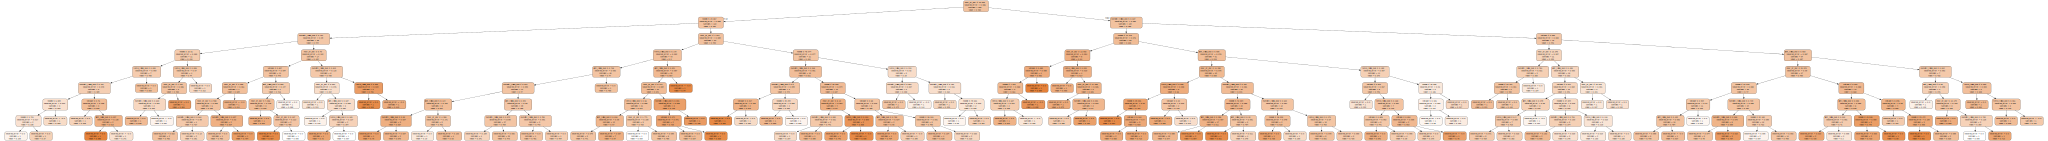

In [54]:
import graphviz

# Render and display the image
with open('tree.dot') as f:
    dot_graph = f.read()
graph = graphviz.Source(dot_graph)
graph.render('tree', format='png', cleanup=True)

# Display the image in the notebook
graph
